<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-GIA-model-weights-(LIG-+-Holocene)" data-toc-modified-id="Load-GIA-model-weights-(LIG-+-Holocene)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load GIA model weights (LIG + Holocene)</a></span></li></ul></div>

In [37]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]

import sys
sys.path.append(str(PROJECT_ROOT))
from bahamas_lig.utils import *
import matplotlib.gridspec as gridspec
import string
from tqdm import tqdm

### Load GIA model weights (LIG + Holocene)

In [38]:
hol_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_Hol_new"
hol_inference_dir = PROJECT_ROOT / "model_outputs/holocene"
lig_model_dir = PROJECT_ROOT / "model_outputs/get_GIA/output_new"
lig_inference_dir = PROJECT_ROOT / "model_outputs/"
# data_dir = PROJECT_ROOT / "data/"

holocene_dataframe = get_model_status(hol_inference_dir,hol_model_dir)
lig_dataframe = get_model_status(lig_inference_dir,lig_model_dir)

# holocene_dataframe = pd.read_csv('/limestone/jupyter/blake/bahamas-gia/data/processed/BMA_weighted_models_holocene.csv', index_col=0)

In [39]:
lig_predict_dir = str(lig_inference_dir)+'/'+str('pymc3_post_predict_2021')
lig_predict_list=[o[:-4] for o in os.listdir(lig_predict_dir) if '.pkl' in o]

In [40]:
preds = {}
for f in lig_predict_list:
    preds[f]=load(lig_predict_dir+'/'+f+'.pkl')

In [41]:
combined_weight = lig_dataframe.copy()
X_new = np.linspace(115, 130, 200)[:, np.newaxis]
# for i in range(len(holocene_dataframe)):
#     ids=((lig_dataframe['LMV']==holocene_dataframe['LMV'][i]) & (lig_dataframe['UMV']==holocene_dataframe['UMV'][i]) & (lig_dataframe['Lithosphere']==holocene_dataframe['Lithosphere'][i]))
#     combined_weight.at[ids,'weight']=combined_weight[ids]['weight'].values*holocene_dataframe['weight'].values[i]
combined_weight['weight'] = combined_weight['weight']/np.sum(combined_weight['weight'].values)

    
gmsl=weighted_trace(preds,combined_weight,iters=10000)
## Can use this line to recode the regional-wide subsidence added to the data. 
## Here I remove the flat 2.5 and add 0.023 m per ky and some extra white noise (mu=0,sigma=0.4)
gmsl = gmsl - 2.5 + np.tile(X_new,gmsl.shape[0]).T*.023+np.random.normal(0,.4,gmsl.shape)


In [42]:
def pre_load_models(comp):
    models = {}
    for m in tqdm(list(comp.index)):
        GIA_MODEL, age, model_dims = load_model(m)
        models[m] = GIA_MODEL
    return models

def weighted_rsl_trace(pred_list, comp, lat, lon, var="f_pred",iters=20000):
    model_names = list(comp.index)
    weighted_trace =[]
    for i in range(iters):
        choice = np.random.choice(np.arange(len(comp)), 1, p=comp['weight'])
        key=comp.index[choice][0]
        f_preds = pred_list[key][var]
        C=np.random.choice(np.arange(len(f_preds)), 1)
        gmsl=f_preds[C].ravel()
        
        GIA_MODEL = models[key]
        if i == 0:
            GIA_MODEL, age, model_dims = load_model(key)
            
        GIA_MODEL = [GIA_MODEL[a] for a in np.argsort(age)]
        age = np.sort(age)
            
        z_functions = interpolation_functions(
            [lat], [lon], GIA_MODEL, age, model_dims
        )
        
        GIA_to_add = z_functions[0](X_new).ravel()

        weighted_trace.append(GIA_to_add+gmsl)
    weighted_trace=np.array(weighted_trace)
    return weighted_trace

def clear_spines(ax):
    """
    Removes spines from the top, left, and right of a matplotlib axis.
    """
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yticks([])

In [43]:
data = load_data()
models = pre_load_models(combined_weight)

100%|██████████| 579/579 [00:25<00:00, 22.55it/s]


100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


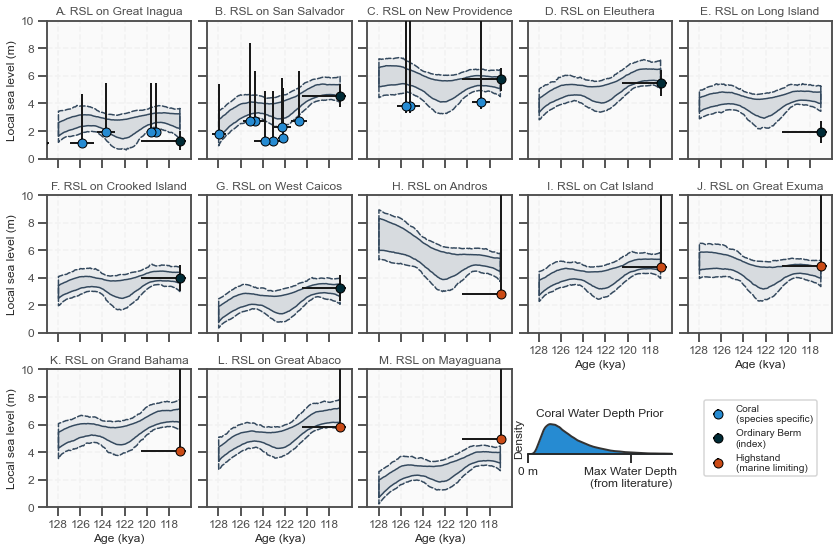

In [46]:
within_LIG = np.logical_and(X_new>117,X_new<128)

L=[]
for x,y in zip(data['i_lat'], data['i_lon']):
    if (x, y) not in L and (y, x ) not in L:
        L.append((x, y))
k=1

color_list=[6,8,7]
sns.set_context('talk')
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".95",
        "grid.linestyle": u"--",
    },
)
f_size=12
bandwidth_for_kde=0.05

flatui = ["#D08770", "#BF616A", "#A3BE8C", "#B48EAD", "#34495e", "#5E81AC","#268bd2", "#cb4b16", "#002b36"]
cs = sns.color_palette(flatui)

letters=list(string.ascii_uppercase)
fig=plt.figure(figsize=(12,8))
for l in tqdm(L):
    plt.subplot(3,5,k)
    inference_all=weighted_rsl_trace(preds,combined_weight,l[0],l[1],iters=1000)
#     like_all=np.zeros(X_new.size)
#     for i in range(X_new.size):
#         time_slice = inference_all[:,i][~np.isnan(inference_all[:,i])]
#         like_all[i]=dy[np.argmax(scipy.stats.gaussian_kde(time_slice,bw_method=bw)(dy))]
    plot_gmsl_inference(X_new[within_LIG],inference_all[:,within_LIG.ravel()]-2.5,cs[4],plt.gca(),False)
#     plt.gca().get_legend().remove()
    filtered = data[(data['i_lat']==l[0]) & (data['i_lon']==l[1])]
    
#         plt.legend(loc='best', fontsize=f_size)
    for j,t in enumerate(data['type'].unique()):
        f = filtered[filtered['type']==t]
        if (t == 'ordinary berm') or (t == 'highstand_marine'):
            xerr = [.5*np.ones_like(f["age"]),3.5*np.ones_like(f["age"])]
        else:
            xerr = [f["age_uncertainty"],f["age_uncertainty"]]
        
        yerr = [f["elevation_uncertainty"],f["elevation_uncertainty"]+f["water depth 97.5%"].fillna(0)]
        
        if (t == 'highstand_marine'):
            yerr = [0*np.ones_like(f["age"]),4*f["elevation_uncertainty"]+f["water depth 97.5%"].fillna(0)]
        
        rsl = f['elevation']
        if t=='ordinary berm':
            rsl -= f["water depth mean (m)"]
            yerr = [f["elevation_uncertainty"]+2*f["Param 2"],f["elevation_uncertainty"]+2*f["Param 2"]]
#         if t=='coral':
#             rsl += f["water depth 2.5%"]
            
        plt.errorbar(
            f["age"],
            rsl,
            xerr=xerr,
            yerr=yerr,
            linestyle="none",lw=2,
            label="Observations",mfc=cs[color_list[j]],color=(.1,.1,.1),
            marker='o',mec='k',zorder=100
        )

    
    plt.gca().set_title(
        letters[k-1] +". RSL on "+filtered['island'].values[0],fontsize=f_size)

#     plt.gca().set_aspect(1/2)
#     plt.gca().set_xlim(117,130)
#     plt.gca().invert_xaxis()

#     plt.gca().set_aspect(1/2)
    

    if k%5==1:
        plt.gca().set_yticks(np.arange(-6,20,2))
        plt.gca().set_yticklabels(np.arange(-6,20,2),fontsize=f_size)
        plt.gca().set_ylabel("Local sea level (m)", fontsize=f_size)
    else:
        plt.gca().set_yticks(np.arange(-6,20,2))
        plt.gca().set_yticklabels([],fontsize=f_size)
    plt.gca().set_ylim([0, 10])
    
    plt.gca().set_xlim([116,129])
    plt.gca().invert_xaxis()
    if k>=9:
        plt.gca().set_xticks(np.arange(128,116,-2))
        plt.gca().set_xticklabels(np.arange(128,116,-2),fontsize=f_size)
        plt.gca().set_xlabel("Age (kya)",fontsize=f_size)
    else:
        plt.gca().set_xticks(np.arange(128,116,-2))
        plt.gca().set_xticklabels([],fontsize=f_size)
    k+=1
    
  
sns.set_style('ticks')
sns.set_style(
    "ticks",
    {

       'axes.facecolor': 'white'

    },
)

plt.subplot(3,5,k)  

A = np.random.wald(2,5,100000)
sns.kdeplot(A,  bw_method=bandwidth_for_kde, gridsize=1000, shade=True, color=cs[color_list[0]], lw=0,alpha=1)
sns.kdeplot(A,  bw_method=bandwidth_for_kde, gridsize=1000, shade=False, color=(.2,.2,.2), lw=2,alpha=1)
# sns.kdeplot(a_draws)
clear_spines(plt.gca())
plt.gca().grid(False)
plt.gca().set_aspect(3)
plt.gca().set_xlim(0,7)
plt.gca().set_ylabel('Density', fontsize=f_size)
plt.gca().set_xticks([0,5])
plt.gca().set_xticklabels(['0 m','Max Water Depth\n(from literature)'],fontsize=f_size)
_=plt.gca().set_title('Coral Water Depth Prior',fontsize=f_size)

k+=1
plt.subplot(3,5,k)  
plt.errorbar(
    [],
    [],
    xerr=[],
    yerr=[],
    linestyle="none",
    label="Coral\n(species specific)",mfc=cs[color_list[0]],color='k',
    marker='o',mec='k',zorder=100
)
plt.errorbar(
    [],
    [],
    xerr=[],
    yerr=[],
    linestyle="none",
    label="Ordinary Berm\n(index)",mfc=cs[color_list[1]],color='k',
    marker='o',mec='k',zorder=100
)
plt.errorbar(
    [],
    [],
    xerr=[],
    yerr=[],
    linestyle="none",
    label="Highstand\n(marine limiting)",mfc=cs[color_list[2]],color='k',
    marker='o',mec='k',zorder=100
)
hand, labl = plt.gca().get_legend_handles_labels()
plt.legend(hand[-3:], labl[-3:],fontsize=10,loc='center')
clear_spines(plt.gca())
plt.gca().grid(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().set_xticks([])

fig.tight_layout(w_pad=0.1,h_pad=0.0)
fig.savefig("RSL_grid.pdf", bbox_inches="tight", dpi=300)

**Fig. 5.**  Inferred site-specific relative sea level. Last interglacial sea level data included in this analysis are plotted at on panels corresponding to the sample location. Coral dataand water depths come from previous work (27, 29, 48–50). Error bars are roughly 2-$\sigma$.